In [1]:
import pandas as pd
import numpy as np
from dsipts import TimeSeries, RNN,read_public_dataset, LinearTS, Persistent, TFT, DilatedConv

import matplotlib.pyplot as plt
from datetime import timedelta
import logging
import sys
import random




In [2]:
def random_walk(n,level=20):
    tot = np.zeros(n)
    probs = np.zeros(n)
    for i in range(n-1):
        prob = random.random()
        if prob<0.5:
            delta = 1
        else:
            delta = -1
        tot[i+1] = tot[i] + delta
        probs[i+1]= prob +(random.random()/level-0.5/level)
    return tot, probs

In [3]:
N = 20000
random.seed(18)
x, p = random_walk(N)
data = pd.DataFrame({'y':x/x.max(),'p':p,'time':range(N)})

In [4]:
##load the timeseries to the datastructure, adding the hour column and use all the covariates
ts = TimeSeries('weather')
ts.load_signal(data,enrich_cat=[],target_variables=['y'],past_variables= [],future_variables=['p'])
ts.set_verbose(False)
#Let now prepare a model predictin the next 16 step using the past 16 steps 
past_steps = 1
future_steps = 64

In [5]:
split_params = {'perc_train':0.6,'perc_valid':0.2,                             ##if not None it will split 70% 10% 20%
               'range_train':None, 'range_validation':None, 'range_test':None, ## or we can split using ranges for example range_train=['2021-02-03','2022-04-08']
               'past_steps':past_steps,
               'future_steps':future_steps,
               'shift':0,
               'starting_point':None,                                          ## do not skip samples
               'skip_step' : 1                                                 ## distance between two consecutive samples
                             }

In [ ]:
res_tot = {}
for w in np.arange(0,0.1,0.05):
    print(w)
    config = dict(model_configs =dict(
                                        past_steps = past_steps,
                                        future_steps = future_steps,
                                        past_channels = len(ts.past_variables),
                                        future_channels = len(ts.future_variables),
                                        embs = [ts.dataset[c].nunique() for c in ts.cat_var],
                                        cat_emb_dim = 8,
                                        kernel_size = 3,
                                        hidden_RNN=32,
                                        kind='gru',
                                        num_layers_RNN=2,
                                        use_glu=False,
                                         use_bn = False,
                                        dropout_rate=0.25,
                                          optim='torch.optim.Adam',
                                          activation= 'torch.nn.PReLU',
                                         sum_emb = True,
                                         out_channels = len(ts.target_variables),
                                        quantiles= [],
                                        persistence_weight =w,
                                        loss_type='exponential_penalization'
                                        ),
                    scheduler_config = dict(gamma=0.1,step_size=24000000000000000),
                    optim_config = dict(lr = 0.0005,weight_decay=0.00))
    model_linear = DilatedConv(**config['model_configs'],optim_config = config['optim_config'],scheduler_config =config['scheduler_config'],verbose=False )
    ts.set_model(model_linear,config=config,custom_init=True )
    #train the model for 50 epochs with auto_lr_find 
    ts.train_model(dirpath=f"/home/agobbi/Projects/ExpTS/rf/linear",
                   split_params=split_params,
                   batch_size=32,
                   num_workers=2,
                   max_epochs=200,
                   auto_lr_find=True)
    res = ts.inference_on_set(200,4,set='test',rescaling=True)
    res_tot[w] = res.copy()

Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


0.0


/home/agobbi/miniconda3/envs/tt/lib/python3.11/site-packages/pytorch_lightning-1.9.4-py3.11.egg/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /home/agobbi/Projects/ExpTS/rf/linear exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
/home/agobbi/miniconda3/envs/tt/lib/python3.11/site-packages/pytorch_lightning-1.9.4-py3.11.egg/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/agobbi/miniconda3/envs/tt/lib/python3.11/site-packages/pytorch_lightning-1.9.4-py3.11.egg/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled,

Saving losses on file because multigpu not working
0.05


Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/agobbi/miniconda3/envs/tt/lib/python3.11/site-packages/pytorch_lightning-1.9.4-py3.11.egg/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /home/agobbi/Projects/ExpTS/rf/linear exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
/home/agobbi/miniconda3/envs/tt/lib/python3.11/site-packages/pytorch_lightning-1.9.4-py3.11.egg/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/agobbi/miniconda3/envs/tt/lib/python3.11/site-packages/p

In [ ]:
ts.losses.plot()


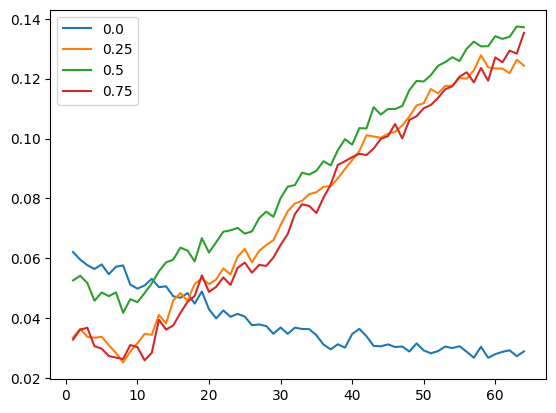

In [10]:
error = {}
for k in res_tot.keys():
    error[k] = res_tot[k].groupby('lag').apply(lambda x: np.sqrt(np.mean((x.y_pred-x.y)**2))).reset_index()
    plt.plot(error[k].lag, error[k][0],label=k)
plt.legend()

In [ ]:
#0.5 --  0.026778758
#0   -- 0.027390912

In [ ]:
##0 -- 0.026814144
##2 -- 0.026652765
##5 -- 0.026685152

In [ ]:
plt.figure()
for i,k in enumerate(res_tot.keys()):
    res_tot[k]['prediction_time'] = res_tot[k].apply(lambda x: int(x.time-x.lag), axis=1)
    if i ==0:
        plt.plot( res_tot[k][ res_tot[k].prediction_time==date].time,  res_tot[k][ res_tot[k].prediction_time==date].y,label='real',alpha=0.5)
    plt.plot( res_tot[k][ res_tot[k].prediction_time==date].time,  res_tot[k][ res_tot[k].prediction_time==date].y_pred,label=k,alpha=0.5)
plt.legend()

In [ ]:


#plt.ylim(res.y.min(),res.y.max())
plt.title('Prediction on test for lag=7')
plt.legend()

In [ ]:
## get the median MSE for each lag
import numpy as np
res.groupby('lag').apply(lambda x: np.nanmean((x.y-x.y_median)**2)).reset_index().rename(columns={0:'error'}) 

In [ ]:
#save model 
ts.save(f"{model_to_use}_test")

In [ ]:
## load the model and check if we obtain the same result

In [ ]:
ts.load(LinearTS,f"{model_to_use}_test",load_last=False)
res = ts.inference_on_set(200,4,set='test',rescaling=True)
error = res.groupby('lag').apply(lambda x: np.nanmean((x.y-x.y_median)**2)).reset_index().rename(columns={0:'error'}) 
error

In [ ]:
##print the mean MSE along the lag steps
plt.plot(error.lag,error.error)

In [ ]:
%matplotlib inline
lag = 7
try:
    %matplotlib qast
    to_plot = res
except:
    print('better to have qt, i will reduce the dataset')
    plt.figure(figsize=(15,7))
    to_plot = res[res.time>pd.to_datetime('2020-12-28')]
plt.plot(to_plot[to_plot.lag==lag].time, to_plot[to_plot.lag==lag].y,label='real',alpha=0.5)
plt.plot(to_plot[to_plot.lag==lag].time, to_plot[to_plot.lag==lag].y_median,label='median',alpha=0.5)
plt.fill_between(to_plot[to_plot.lag==lag].time, to_plot[to_plot.lag==lag].y_low , to_plot[to_plot.lag==lag].y_high, alpha=0.2,label='error band')

plt.title('Prediction on test for lag=7')
plt.legend()

In [ ]:
tot = pd.read_csv('/home/agobbi/Projects/ExpTS/csv/prova_test_tot_predictions.csv')
tot.time = pd.to_datetime(tot.time)

In [ ]:
pers = tot[(tot.model=='persistent_weather_1')]

In [ ]:
%matplotlib inline
lag = 7
try:
    %matplotlib qast
    to_plot = pers
except:
    print('better to have qt, i will reduce the dataset')
    plt.figure(figsize=(15,7))
    to_plot = pers[pers.time>pd.to_datetime('2020-12-28')]
plt.plot(to_plot[to_plot.lag==lag].time, to_plot[to_plot.lag==lag].y,label='real',alpha=0.5)
plt.plot(to_plot[to_plot.lag==lag].time, to_plot[to_plot.lag==lag].y_pred,label='median',alpha=0.5)
plt.fill_between(to_plot[to_plot.lag==lag].time, to_plot[to_plot.lag==lag].y_low , to_plot[to_plot.lag==lag].y_high, alpha=0.2,label='error band')

plt.title('Prediction on test for lag=7')
plt.legend()